In [2]:
# imports

import re
import spacy
import en_core_web_sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.interactiveshell import InteractiveShell
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d

In [3]:
# import configurations

InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [4]:
# read file

df = pd.read_pickle("../data/interim/tweets_verified_money_2020-2021.pkl")
display(df[['tweet', 'money']])

,tweet,money
0,Bitcoin the worst decision i made this decade,[]
1,If you ask someone what they'd do if they went...,[]
2,#bitcoin rally begun in 2013 and it reached a ...,"[2013, 20000, 2017, 3]"
3,Wishing all #Bitcoin Ultra Enthusiasts a very ...,"[2020, 1, 2, 2, 8, 0]"
4,"Breaking down Bitcoin’s 9,000,000% rise in las...","[9000000, 9478]"
...,...,...
312516,@Bitcoin__art Fair enough 😅😅😅,[]
312517,Happy New Year #Bitcoin https://t.co/HdUQNDKUUA,[]
312518,"@rubiconcapital_ Buy bitcoin &amp; chill, defu...",[]
312519,Bitcoin faces uncertain 2022 after record year...,"[2022, 76, 4, 1, 76, 4, 1]"


In [5]:
# get bitcoin past data

df_bitcoin = pd.read_pickle("../data/cleaned/bitcoin_value_2020-now_cleaned.pkl")
df_bitcoin = df_bitcoin[['datetime', 'open_bitcoin']]
df_bitcoin['datetime'] = df_bitcoin['datetime'].astype(str)

In [6]:
df_exploded = df.explode('money')
df_exploded['money'] = df_exploded['money'].astype('float')
df_exploded['date'] = df_exploded['created_at'].dt.date
df_exploded['date'] = df_exploded['date'].astype(str)

In [7]:
df_merged = pd.merge(df_exploded,
                       df_bitcoin,
                       how = "left",
                       left_on = "date",
                       right_on = "datetime")

In [8]:
df_merged = df_merged[(df_merged.money > df_merged.open_bitcoin*0.25) & (df_merged.money < df_merged.open_bitcoin*1.75)]
df_money_bytweet = df_merged.groupby(['id','tweet', 'open_bitcoin']).agg({"money" : "mean"}).reset_index()

In [9]:
df_money_bytweet[['id', 'money']].to_pickle("../data/cleaned/by_id_verified_money_2020-2021.pkl")

,created_at,money
0,2020-01-01,2635.536232
1,2020-01-02,2208.724138
2,2020-01-03,2928.441860
3,2020-01-04,2019.000000
4,2020-01-05,2671.083333
...,...,...
719,2021-12-27,42615.022727
720,2021-12-28,47616.978261
721,2021-12-29,47188.194444
722,2021-12-30,47675.513514


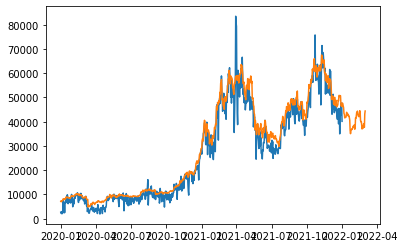

In [10]:
df_bydate_money = df_merged.groupby(df_merged['created_at'].dt.date).agg({"money" : "mean"}).reset_index()
df_bydate_money

plt.plot(df_bydate_money['created_at'],df_bydate_money['money'])
plt.plot(pd.to_datetime(df_bitcoin['datetime']),df_bitcoin['open_bitcoin'])

In [11]:
df_bydate_money['created_at'] = df_bydate_money['created_at'].astype(str)
df_merged_bydate = pd.merge(df_bydate_money,
                       df_bitcoin,
                       how = "left",
                       left_on = "created_at",
                       right_on = "datetime")
df_merged_bydate


,created_at,money,datetime,open_bitcoin
0,2020-01-01,2635.536232,2020-01-01,7200.77
1,2020-01-02,2208.724138,2020-01-02,6965.49
2,2020-01-03,2928.441860,2020-01-03,7345.00
3,2020-01-04,2019.000000,2020-01-04,7354.19
4,2020-01-05,2671.083333,2020-01-05,7357.64
...,...,...,...,...
719,2021-12-27,42615.022727,2021-12-27,50701.44
720,2021-12-28,47616.978261,2021-12-28,47543.74
721,2021-12-29,47188.194444,2021-12-29,46464.66
722,2021-12-30,47675.513514,2021-12-30,47120.88


In [15]:
df_merged_bydate['normalized_money'] = (df_merged_bydate['money'] - df_merged_bydate['open_bitcoin'])/df_merged_bydate['open_bitcoin']
df_merged_bydate


,created_at,money,datetime,open_bitcoin,normalized_money
0,2020-01-01,2635.536232,2020-01-01,7200.77,-0.633992
1,2020-01-02,2208.724138,2020-01-02,6965.49,-0.682905
2,2020-01-03,2928.441860,2020-01-03,7345.00,-0.601301
3,2020-01-04,2019.000000,2020-01-04,7354.19,-0.725463
4,2020-01-05,2671.083333,2020-01-05,7357.64,-0.636965
...,...,...,...,...,...
719,2021-12-27,42615.022727,2021-12-27,50701.44,-0.159491
720,2021-12-28,47616.978261,2021-12-28,47543.74,0.001540
721,2021-12-29,47188.194444,2021-12-29,46464.66,0.015572
722,2021-12-30,47675.513514,2021-12-30,47120.88,0.011770


In [13]:
df_merged_bydate[['created_at', 'normalized_money']].to_pickle("../data/cleaned/by_date_normalized_money_2020-2021.pkl")

In [14]:
df_merged_bydate[['created_at', 'normalized_money']]

,created_at,normalized_money
0,2020-01-01,-1.732184
1,2020-01-02,-2.153626
2,2020-01-03,-1.508160
3,2020-01-04,-2.642491
4,2020-01-05,-1.754553
...,...,...
719,2021-12-27,-0.189755
720,2021-12-28,0.001538
721,2021-12-29,0.015333
722,2021-12-30,0.011634
